# Projet MLOPS - Prédiction du prix d'une course en taxi

Nous souhaitons prédire le prix d'une course de taxi (variable à expliquer) en fonction des caractéristiques qui la composent comme le nombre de passagers, la distance parcourue, la durée de la course... (variables eplicatives)

In [1]:
#Importation des packages
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

## Les fonctions  

Dans cette section, vous retrouverez toutes les fonctions utilisées.

In [2]:
def extract(data_dir, fich):
    """ Extract a temporal slice of data for a given data source.
    
    Parameters
    ----------
    data_dir: str
        chemin du fichier.
    prefix: str
        nom du fichier
    """
    
    file_path = os.path.join(data_dir, f'{fich}.csv')

    if os.path.isfile(file_path):
        df= pd.read_csv(file_path)
    else :
        return "pas de data"
    
    return df

In [3]:
def info_df(df):
    """fonction qui donne les dimensions et qui liste les variables du data frame
    
    Parameters
    ----------
    df : data frame
        nom du data frame utilisé dans l'analyse (e.g. taxi)
    """
    
    #Dimensions
    dim=df.shape
    print(f'le fichier contient {dim[0]} individus et {dim[1]} variables')
          
    #Libellé des colonnes
    colonnes=df.columns
    print("\nLes variables du fichier sont : ")
    for col in colonnes :
          print("\t-",col)

In [4]:
def clean(df):
    """fonctions qui permet de traiter les données manquantes, les doublons et les données aberrantes
    
    Parameters
    ----------
    df : data frame
        nom du data frame utilisé dans l'analyse (e.g. taxi)
    """
    
    #données manquantes : on supprime les lignes concernées
    if df.isna().any().any():
        df=df[-df.isna().any(axis=1)]
        print("suppression des données manquantes effectuées\n")
    else :
        print("il n'y a pas de données manquantes\n")
        
    #doublons : on les supprime
    if df.duplicated().sum()!=0:
        df.drop_duplicates()
        print("suppression des doublons effectuée\n")
    else :
        print("il n'y a pas de doublons\n")
        
    #modification du type des colonnes
    df=df.astype({'VendorID':'category', 'passenger_count':'int', 'RatecodeID':'category', 
                  'store_and_fwd_flag':'category', 'payment_type':'category','PULocationID':'category',
                  'DOLocationID':'category'})
    df['tpep_pickup_datetime']=pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime']=pd.to_datetime(df['tpep_dropoff_datetime'])
    print("type des colonnes modifiées : ")
    print(df.dtypes)
    
    #données aberrantes
    print("\ntraitement des données aberrantes :")
    #on supprime les lignes pour lesquelles RateCodeID=99 (aucune signification)
    if (df['RatecodeID'] == 99.0).any():
        df.drop(df[df['RatecodeID']==99.0].index,inplace=True)
        print("\t-on supprime les lignes pour lesquelles RateCodeID=99 (aucune signification)")
    
    #on supprime les lignes pour lesquelles trip_distance <0 ou >10000 (donnée abérrante)
    if ((df['trip_distance']>=10000) | (df['trip_distance']<=0.0)).any() :
        df.drop(df[(df['trip_distance']>=10000) | (df['trip_distance']<=0.0)].index,inplace=True)
        print("\t-on supprime les lignes pour lesquelles trip_distance <0 ou >10000 (donnée abérrante)")
    
    #on supprime les lignes pour lesquelles le montant de la course est négatif 
    #(donnée abérrante, ou remboursement non utile pour prédire le prix de la course)
    if (df['fare_amount']<0).any() :
        df.drop(df[df['fare_amount']<0].index,inplace=True)
        print("\t-on supprime les lignes pour lesquelles le montant de la course est négatif (donnée abérrante, ou remboursement non utile pour prédire le prix de la course)")
    
    #on supprime les lignes pour lesquelles passenger_count=0 (donnée abérrante)
    if (df['passenger_count']==0).any() :
        df.drop(df[df['passenger_count']==0].index,inplace=True)
        print("\t-on supprime les lignes pour lesquelles passenger_count=0 (donnée abérrante)")
    
    #on supprime les lignes pour lesquelles l'année de départ !=2020 et le mois de départ != 05 (donnée abérrante)
    if ((df['tpep_pickup_datetime'].dt.year!=2020) & (df['tpep_pickup_datetime'].dt.month!=5)).any() :
        df.drop(df[df['tpep_pickup_datetime'].dt.year!=2020].index,inplace=True)
        df.drop(df[df['tpep_pickup_datetime'].dt.month!=5].index,inplace=True)
        print("\t-on supprime les lignes pour lesquelles l'année de départ !=2020 et le mois de départ != 05 (donnée abérrante)")
    
    print("\nsuppression des données aberrantes effectuées\n")
    
    #dimensions
    dim=df.shape
    print(f'désormais, le fichier contient {dim[0]} individus et {dim[1]} variables')
    
    return df

In [5]:
def moment_journee(heure):
    """fonction qui permet de récupérer le moment de la journée en fonction d'une heure passée en paramètre
    
    Parameters
    ----------
    heure : int
        heure de la journée dont ou souhaite récupérer le moment
    """
    if heure>=5 and heure<12 :
        return("matin")
    elif heure>=12 and heure<14 :
        return('midi')
    elif heure>=14 and heure<18 :
        return("après-midi")
    elif heure>=18 and heure<21 :
        return('soir')
    else :
        return('nuit')

In [6]:
def moment_semaine(jour):
    """fonction qui permet de récupérer le moment de la semaine pour un jour passée en paramètre
    
    Parameters
    ----------
    jour : int
        numéro du jour dont ou souhaite récupérer le moment de la semaine (semaine ou week-end) : 0 pour lundi, 1 pour mardi...
    """
    if jour<=4 :
        return("semaine")#Semaine
    else :
        return('week-end')#Week-End

In [7]:
def rep_variable(df, var):
    """fonction qui permet d'afficher un tableau de la répartition des individus en fonction des modalités de la variable du data frame passés en paramètre
    
    Parameters
    ----------
    df : str
        nom du data frame
    var : str
        nom de la variable que   
    """
    print(df[var].value_counts())

## Importation des données 

In [8]:
taxi = extract(data_dir= r"F:\siad\m2\MLops", fich='yellow_tripdata_2020-05')

C:\Users\ffevrier\AppData\Local\Temp\ipykernel_4216\3845343347.py:15: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(file_path)


In [9]:
info_df(taxi)

le fichier contient 348371 individus et 18 variables

Les variables du fichier sont : 
	- VendorID
	- tpep_pickup_datetime
	- tpep_dropoff_datetime
	- passenger_count
	- trip_distance
	- RatecodeID
	- store_and_fwd_flag
	- PULocationID
	- DOLocationID
	- payment_type
	- fare_amount
	- extra
	- mta_tax
	- tip_amount
	- tolls_amount
	- improvement_surcharge
	- total_amount
	- congestion_surcharge


In [10]:
#aperçu du df
taxi.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-05-01 00:02:28,2020-05-01 00:18:07,1.0,0.0,1.0,N,234,256,1.0,12.2,3.0,0.5,2.40,0.0,0.3,18.40,2.5
1,1.0,2020-05-01 00:23:21,2020-05-01 00:26:01,2.0,0.4,1.0,N,264,264,1.0,4.0,0.5,0.5,0.50,0.0,0.3,5.80,0.0
2,1.0,2020-05-01 00:54:58,2020-05-01 00:57:11,1.0,0.3,1.0,N,264,264,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0
3,1.0,2020-05-01 00:07:10,2020-05-01 00:12:46,1.0,1.7,1.0,N,107,229,2.0,7.0,3.0,0.5,0.00,0.0,0.3,10.80,2.5
4,1.0,2020-05-01 00:55:47,2020-05-01 01:01:54,0.0,0.9,1.0,N,237,262,1.0,6.0,3.0,0.5,1.20,0.0,0.3,11.00,2.5
5,1.0,2020-05-01 00:38:37,2020-05-01 01:03:08,0.0,12.0,1.0,N,140,28,1.0,35.5,3.0,0.5,0.00,0.0,0.3,39.30,2.5
6,1.0,2020-05-01 00:09:46,2020-05-01 00:27:44,1.0,2.9,1.0,N,79,237,2.0,12.0,3.0,0.5,0.00,0.0,0.3,15.80,2.5
7,1.0,2020-05-01 00:22:48,2020-05-01 00:28:58,1.0,1.5,1.0,N,140,263,1.0,7.0,3.0,0.5,2.15,0.0,0.3,12.95,2.5
8,1.0,2020-05-01 00:57:59,2020-05-01 01:07:48,1.0,2.0,1.0,N,140,230,2.0,9.0,3.0,0.5,0.00,0.0,0.3,12.80,2.5
9,1.0,2020-05-01 00:10:53,2020-05-01 00:14:17,1.0,0.5,1.0,N,239,239,2.0,4.5,3.0,0.5,0.00,0.0,0.3,8.30,2.5


## Qualité des données 

In [11]:
taxi=clean(taxi)

suppression des données manquantes effectuées

il n'y a pas de doublons

type des colonnes modifiées : 
VendorID                       category
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int32
trip_distance                   float64
RatecodeID                     category
store_and_fwd_flag             category
PULocationID                   category
DOLocationID                   category
payment_type                   category
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
dtype: object

traitement des données aberrantes :
	-on supprime les lignes pour lesquelles RateCodeID=99 (aucune signification)
	-on supprime les lignes pour lesquelles trip_d

In [12]:
#aperçu du df
taxi.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
1,1.0,2020-05-01 00:23:21,2020-05-01 00:26:01,2,0.40,1.0,N,264,264,1.0,4.0,0.5,0.5,0.50,0.0,0.3,5.80,0.0
2,1.0,2020-05-01 00:54:58,2020-05-01 00:57:11,1,0.30,1.0,N,264,264,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0
3,1.0,2020-05-01 00:07:10,2020-05-01 00:12:46,1,1.70,1.0,N,107,229,2.0,7.0,3.0,0.5,0.00,0.0,0.3,10.80,2.5
6,1.0,2020-05-01 00:09:46,2020-05-01 00:27:44,1,2.90,1.0,N,79,237,2.0,12.0,3.0,0.5,0.00,0.0,0.3,15.80,2.5
7,1.0,2020-05-01 00:22:48,2020-05-01 00:28:58,1,1.50,1.0,N,140,263,1.0,7.0,3.0,0.5,2.15,0.0,0.3,12.95,2.5
8,1.0,2020-05-01 00:57:59,2020-05-01 01:07:48,1,2.00,1.0,N,140,230,2.0,9.0,3.0,0.5,0.00,0.0,0.3,12.80,2.5
9,1.0,2020-05-01 00:10:53,2020-05-01 00:14:17,1,0.50,1.0,N,239,239,2.0,4.5,3.0,0.5,0.00,0.0,0.3,8.30,2.5
10,2.0,2020-05-01 00:09:47,2020-05-01 00:22:19,1,3.37,1.0,N,151,244,1.0,13.0,0.5,0.5,3.58,0.0,0.3,17.88,0.0
11,2.0,2020-05-01 00:38:40,2020-05-01 00:46:03,1,1.41,1.0,N,152,41,2.0,7.0,0.5,0.5,0.00,0.0,0.3,8.30,0.0
12,2.0,2020-05-01 00:32:15,2020-05-01 00:37:49,1,1.06,1.0,N,107,137,2.0,6.0,0.5,0.5,0.00,0.0,0.3,9.80,2.5


## Création de nouvelles variables 

Pour ajouter de la plus-value à notre analyse, nous avons décidé de créer de nouvelles variables.

In [13]:
#Création d'un champ durée du trajet :
taxi['diff']=taxi['tpep_dropoff_datetime']-taxi['tpep_pickup_datetime']
taxi['duree']=round(taxi['diff'].dt.seconds/60,2)

In [14]:
#Création d'un champ heure :
taxi['heure']=taxi['tpep_pickup_datetime'].dt.hour

In [15]:
#création d'un champ moment de la journée
taxi['moment']=taxi['heure'].map(moment_journee)

In [16]:
#création d'un champ jour
taxi['jour']=taxi['tpep_pickup_datetime'].dt.weekday

In [17]:
#création d'un champ moment de la semaine
taxi['semaine']=taxi['jour'].map(moment_semaine)

In [18]:
info_df(taxi)

le fichier contient 269674 individus et 24 variables

Les variables du fichier sont : 
	- VendorID
	- tpep_pickup_datetime
	- tpep_dropoff_datetime
	- passenger_count
	- trip_distance
	- RatecodeID
	- store_and_fwd_flag
	- PULocationID
	- DOLocationID
	- payment_type
	- fare_amount
	- extra
	- mta_tax
	- tip_amount
	- tolls_amount
	- improvement_surcharge
	- total_amount
	- congestion_surcharge
	- diff
	- duree
	- heure
	- moment
	- jour
	- semaine


In [19]:
#aperçu du df
taxi.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,diff,duree,heure,moment,jour,semaine
1,1.0,2020-05-01 00:23:21,2020-05-01 00:26:01,2,0.40,1.0,N,264,264,1.0,...,0.0,0.3,5.80,0.0,0 days 00:02:40,2.67,0,nuit,4,semaine
2,1.0,2020-05-01 00:54:58,2020-05-01 00:57:11,1,0.30,1.0,N,264,264,2.0,...,0.0,0.3,4.80,0.0,0 days 00:02:13,2.22,0,nuit,4,semaine
3,1.0,2020-05-01 00:07:10,2020-05-01 00:12:46,1,1.70,1.0,N,107,229,2.0,...,0.0,0.3,10.80,2.5,0 days 00:05:36,5.60,0,nuit,4,semaine
6,1.0,2020-05-01 00:09:46,2020-05-01 00:27:44,1,2.90,1.0,N,79,237,2.0,...,0.0,0.3,15.80,2.5,0 days 00:17:58,17.97,0,nuit,4,semaine
7,1.0,2020-05-01 00:22:48,2020-05-01 00:28:58,1,1.50,1.0,N,140,263,1.0,...,0.0,0.3,12.95,2.5,0 days 00:06:10,6.17,0,nuit,4,semaine
8,1.0,2020-05-01 00:57:59,2020-05-01 01:07:48,1,2.00,1.0,N,140,230,2.0,...,0.0,0.3,12.80,2.5,0 days 00:09:49,9.82,0,nuit,4,semaine
9,1.0,2020-05-01 00:10:53,2020-05-01 00:14:17,1,0.50,1.0,N,239,239,2.0,...,0.0,0.3,8.30,2.5,0 days 00:03:24,3.40,0,nuit,4,semaine
10,2.0,2020-05-01 00:09:47,2020-05-01 00:22:19,1,3.37,1.0,N,151,244,1.0,...,0.0,0.3,17.88,0.0,0 days 00:12:32,12.53,0,nuit,4,semaine
11,2.0,2020-05-01 00:38:40,2020-05-01 00:46:03,1,1.41,1.0,N,152,41,2.0,...,0.0,0.3,8.30,0.0,0 days 00:07:23,7.38,0,nuit,4,semaine
12,2.0,2020-05-01 00:32:15,2020-05-01 00:37:49,1,1.06,1.0,N,107,137,2.0,...,0.0,0.3,9.80,2.5,0 days 00:05:34,5.57,0,nuit,4,semaine


## Suppression des colonnes inutiles 

Pour la suite de l'analyse, nous allons garder que les colonnes utiles et supprimer les autres.

In [20]:
taxi=taxi.drop(['store_and_fwd_flag', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'congestion_surcharge',
                'fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','diff','heure', 'jour',
                'PULocationID', 'DOLocationID'],
               axis=1)

In [21]:
taxi.dtypes

VendorID           category
passenger_count       int32
trip_distance       float64
RatecodeID         category
payment_type       category
total_amount        float64
duree               float64
moment               object
semaine              object
dtype: object

In [22]:
#suppression des modalités qui ont 0 pour effectif
taxi['VendorID']=taxi['VendorID'].cat.remove_unused_categories()
taxi['RatecodeID']=taxi['RatecodeID'].cat.remove_unused_categories()
taxi['payment_type']=taxi['payment_type'].cat.remove_unused_categories()

In [23]:
info_df(taxi)

le fichier contient 269674 individus et 9 variables

Les variables du fichier sont : 
	- VendorID
	- passenger_count
	- trip_distance
	- RatecodeID
	- payment_type
	- total_amount
	- duree
	- moment
	- semaine


In [24]:
#aperçu du df
taxi.head(10)

,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,total_amount,duree,moment,semaine
1,1.0,2,0.40,1.0,1.0,5.80,2.67,nuit,semaine
2,1.0,1,0.30,1.0,2.0,4.80,2.22,nuit,semaine
3,1.0,1,1.70,1.0,2.0,10.80,5.60,nuit,semaine
6,1.0,1,2.90,1.0,2.0,15.80,17.97,nuit,semaine
7,1.0,1,1.50,1.0,1.0,12.95,6.17,nuit,semaine
8,1.0,1,2.00,1.0,2.0,12.80,9.82,nuit,semaine
9,1.0,1,0.50,1.0,2.0,8.30,3.40,nuit,semaine
10,2.0,1,3.37,1.0,1.0,17.88,12.53,nuit,semaine
11,2.0,1,1.41,1.0,2.0,8.30,7.38,nuit,semaine
12,2.0,1,1.06,1.0,2.0,9.80,5.57,nuit,semaine


## Partie analyse statistique 

Tout d'abord, afin d'améliorer la compréhension de nos graphiques, nous allons modifier les labels des variables de type category de façon à remplacer les numéros par leur libellé.

In [25]:
taxi['VendorID']=taxi['VendorID'].replace([1.0, 2.0],
                                          ['Creative Mobile Technologies', 'Verifone Inc'])
taxi['RatecodeID']=taxi['RatecodeID'].replace([1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
                            ['Standard Rate', 'JFK', 'Newark', 'Nassau or Westchester', 'Negotiated fare', 'Group Ride'])
taxi['payment_type']=taxi['payment_type'].replace([1.0, 2.0,3.0,4.0,5.0,6.0],
                                                  ['Credit Card', 'Cash','No Charge','Dispute','Unknown','Voided Trip'])

In [26]:
#aperçu du df
taxi.head(10)

,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,total_amount,duree,moment,semaine
1,Creative Mobile Technologies,2,0.40,Standard Rate,Credit Card,5.80,2.67,nuit,semaine
2,Creative Mobile Technologies,1,0.30,Standard Rate,Cash,4.80,2.22,nuit,semaine
3,Creative Mobile Technologies,1,1.70,Standard Rate,Cash,10.80,5.60,nuit,semaine
6,Creative Mobile Technologies,1,2.90,Standard Rate,Cash,15.80,17.97,nuit,semaine
7,Creative Mobile Technologies,1,1.50,Standard Rate,Credit Card,12.95,6.17,nuit,semaine
8,Creative Mobile Technologies,1,2.00,Standard Rate,Cash,12.80,9.82,nuit,semaine
9,Creative Mobile Technologies,1,0.50,Standard Rate,Cash,8.30,3.40,nuit,semaine
10,Verifone Inc,1,3.37,Standard Rate,Credit Card,17.88,12.53,nuit,semaine
11,Verifone Inc,1,1.41,Standard Rate,Cash,8.30,7.38,nuit,semaine
12,Verifone Inc,1,1.06,Standard Rate,Cash,9.80,5.57,nuit,semaine


Ensuite, pour simplifier l'analyse statistique, nous répartissons les variables qualitatives et les variables quantitatives dans deux data frames différents.

In [27]:
#Création des nouveaux jeux de données
quanti=taxi[['passenger_count','trip_distance','total_amount','duree']]
quali=taxi[['VendorID','RatecodeID','payment_type', 'moment', 'semaine']]

### Variables qualitatives 

Nous allons commencer par analyser les variables qualitatives.

In [28]:
#Statistiques sur les variables qualitatives
quali.describe()

,VendorID,RatecodeID,payment_type,moment,semaine
count,269674,269674,269674,269674,269674
unique,2,6,4,5,2
top,Verifone Inc,Standard Rate,Credit Card,matin,semaine
freq,159937,266901,162741,85533,202391


#### Répartition des variables qualitatives 

In [29]:
#Variable payment_type
rep_variable(taxi, "payment_type")

Credit Card    162741
Cash           103690
No Charge        2384
Dispute           859
Name: payment_type, dtype: int64


In [30]:
#Variable VendorId
rep_variable(taxi, "VendorID")

Verifone Inc                    159937
Creative Mobile Technologies    109737
Name: VendorID, dtype: int64


In [31]:
#Variable RatecodeID
rep_variable(taxi, "RatecodeID")

Standard Rate            266901
JFK                        1560
Negotiated fare             741
Newark                      250
Nassau or Westchester       221
Group Ride                    1
Name: RatecodeID, dtype: int64


In [32]:
#Variable moment
rep_variable(taxi, "moment")

matin         85533
après-midi    79311
soir          40094
midi          38269
nuit          26467
Name: moment, dtype: int64


In [33]:
#Variable semaine
rep_variable(taxi, "semaine")

semaine     202391
week-end     67283
Name: semaine, dtype: int64


#### Représentation des variables qualitatives 

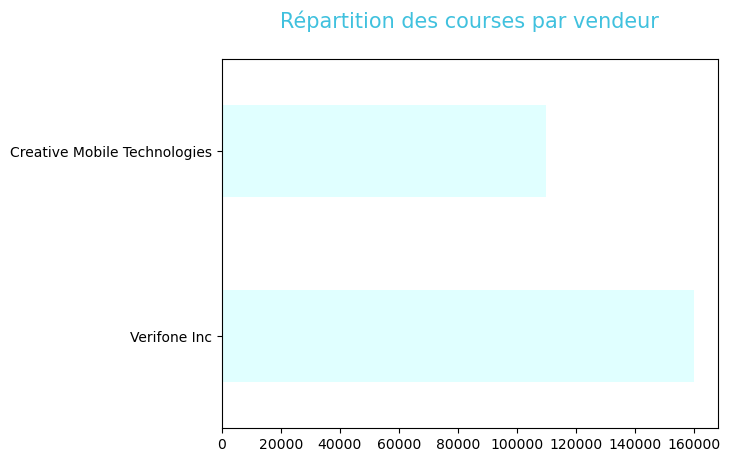

In [34]:
#Variable VendorId
taxi['VendorID'].value_counts().plot.barh(color='lightcyan')
plt.title("Répartition des courses par vendeur\n", fontsize=15, color='#40c1de')
plt.show()

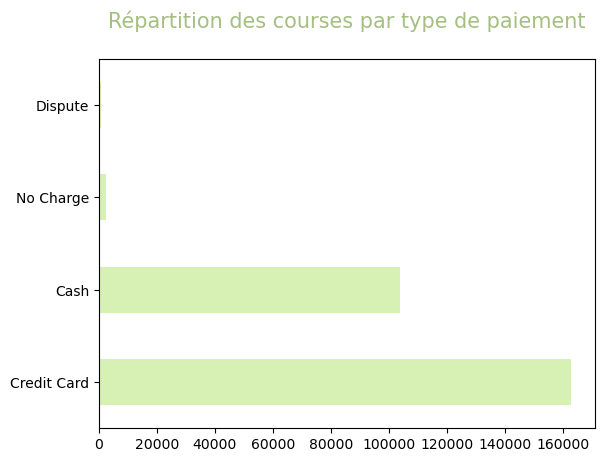

In [35]:
#Variable payment_type
taxi['payment_type'].value_counts().plot.barh(color='#d7f0b3')
plt.title("Répartition des courses par type de paiement\n", fontsize=15, color='#a5bf81')
plt.show()

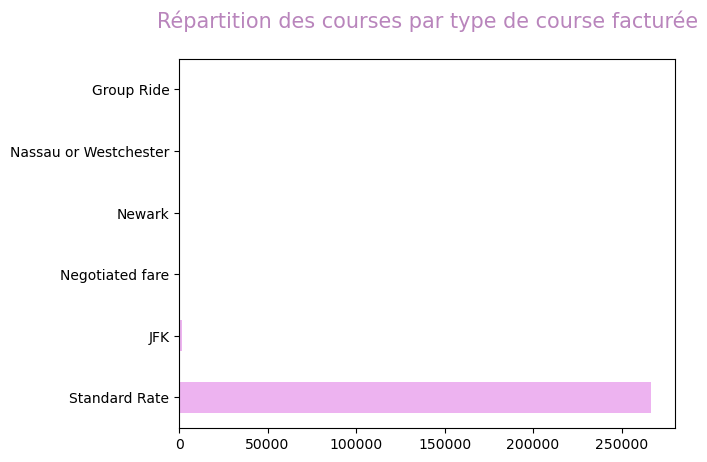

In [36]:
#Variable RatecodeID
taxi['RatecodeID'].value_counts().plot.barh(color='#edb3f0')
plt.title("Répartition des courses par type de course facturée\n", fontsize=15, color='#b985bc')
plt.show()

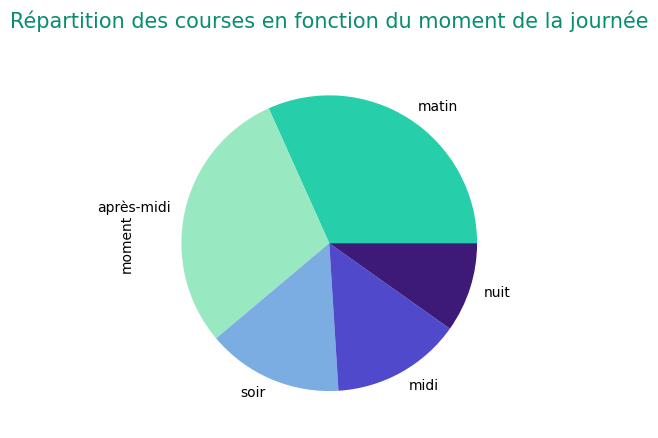

In [37]:
#Variable moment
taxi["moment"].value_counts(normalize=True).plot(kind='pie', colors=['#26ceaa', '#98e8c1', '#7bade2', '#5049cc', '#3d1a78'])
plt.title("Répartition des courses en fonction du moment de la journée\n", fontsize=15, color='#078d70')
plt.show()

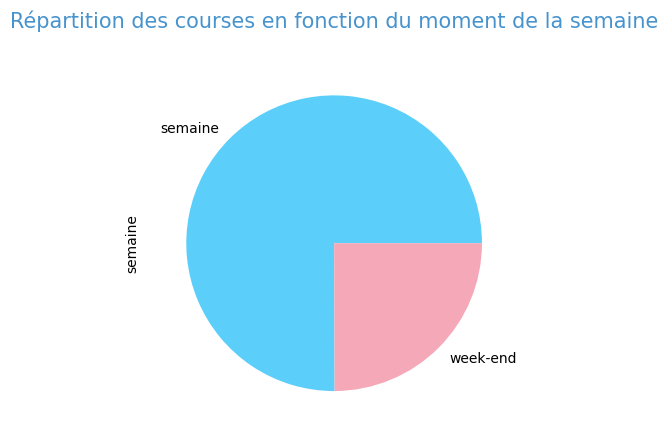

In [38]:
#Variable semaine
taxi["semaine"].value_counts(normalize=True).plot(kind='pie', colors=['#5bcefa', '#f5a9b8'])
plt.title("Répartition des courses en fonction du moment de la semaine\n", fontsize=15, color='#4793cd')
plt.show()

### Variables quantitatives 

Nous allons maintenant analyser les variables quantitatives.

In [39]:
#Statistiques sur les variables qualitatives
quanti.describe()

,passenger_count,trip_distance,total_amount,duree
count,269674.000000,269674.000000,269674.000000,269674.000000
mean,1.368397,2.788779,15.943757,11.877375
std,0.980964,3.540527,12.323514,52.231634
min,1.000000,0.010000,0.000000,0.000000
25%,1.000000,1.000000,9.800000,4.750000
50%,1.000000,1.740000,12.800000,7.750000
75%,1.000000,3.200000,17.800000,12.480000
max,6.000000,305.100000,1042.820000,1438.870000


#### Représentation des variables quantitatives 

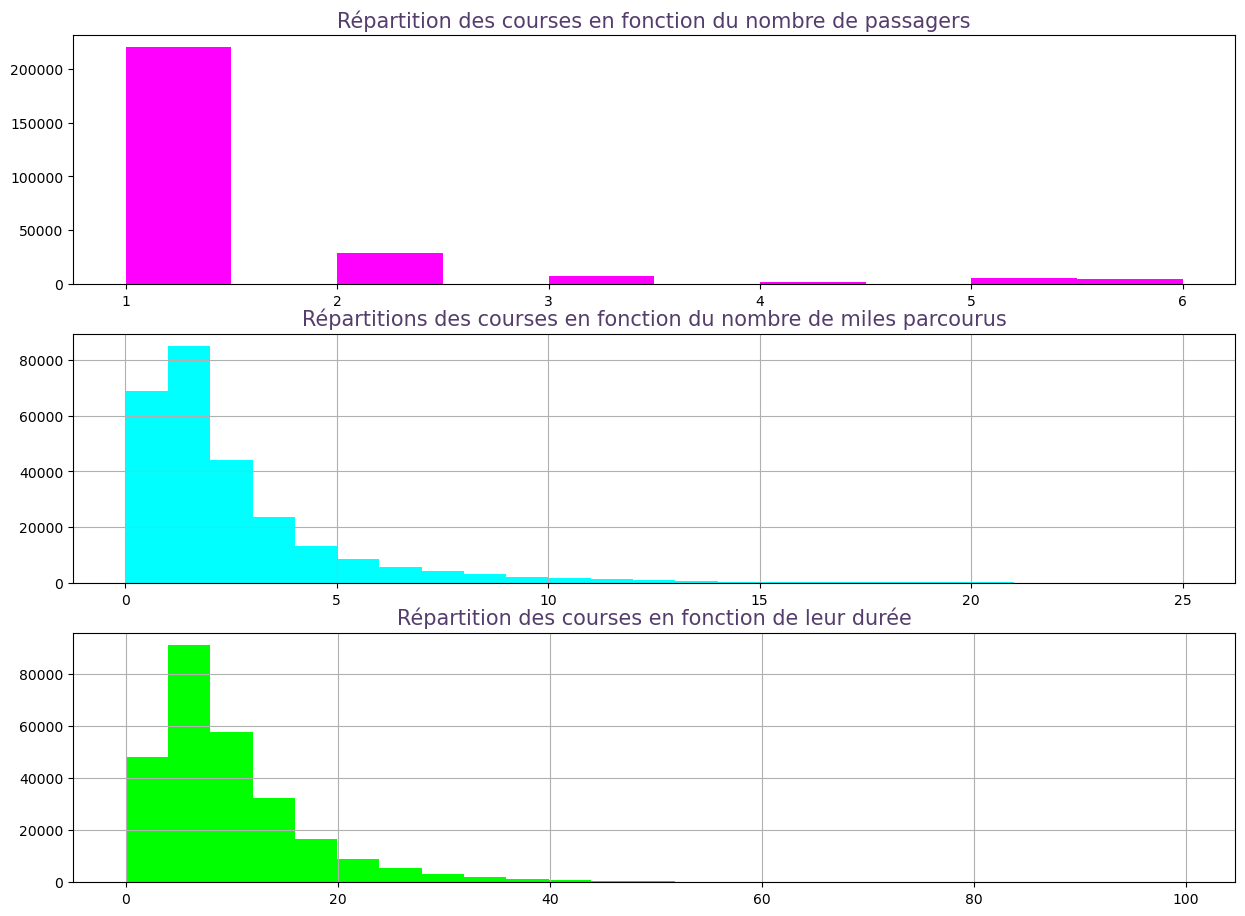

In [40]:
plt.figure(figsize=(15,11))

#Variable passenger_count
plt.subplot(3,1,1)
plt.hist(taxi['passenger_count'],color='magenta')
plt.title("Répartition des courses en fonction du nombre de passagers", fontsize=15, color='#543d6d')

#Variable trip_distance
plt.subplot(3,1,2)
taxi['trip_distance'][taxi['trip_distance']<=25].hist(bins=25,color='cyan')
plt.title("Répartitions des courses en fonction du nombre de miles parcourus", fontsize=15, color='#543d6d')

#Variable duree
plt.subplot(3,1,3)
taxi['duree'][taxi['duree']<=100].hist(bins=25,color='lime')
plt.title("Répartition des courses en fonction de leur durée", fontsize=15, color='#543d6d')

plt.show()

### Croisement de variables 

Désormais, afin de mieux comprendre le lien entre nos variables, nous allons réaliser des statistiques à 2 dimensions en faisant des croisements entre nos variables

#### Variables quantitatives + variable total 

Comme notre variable à expliquer est le total de la course, nous allons croiser nos variables quantitatives avec cette variable.

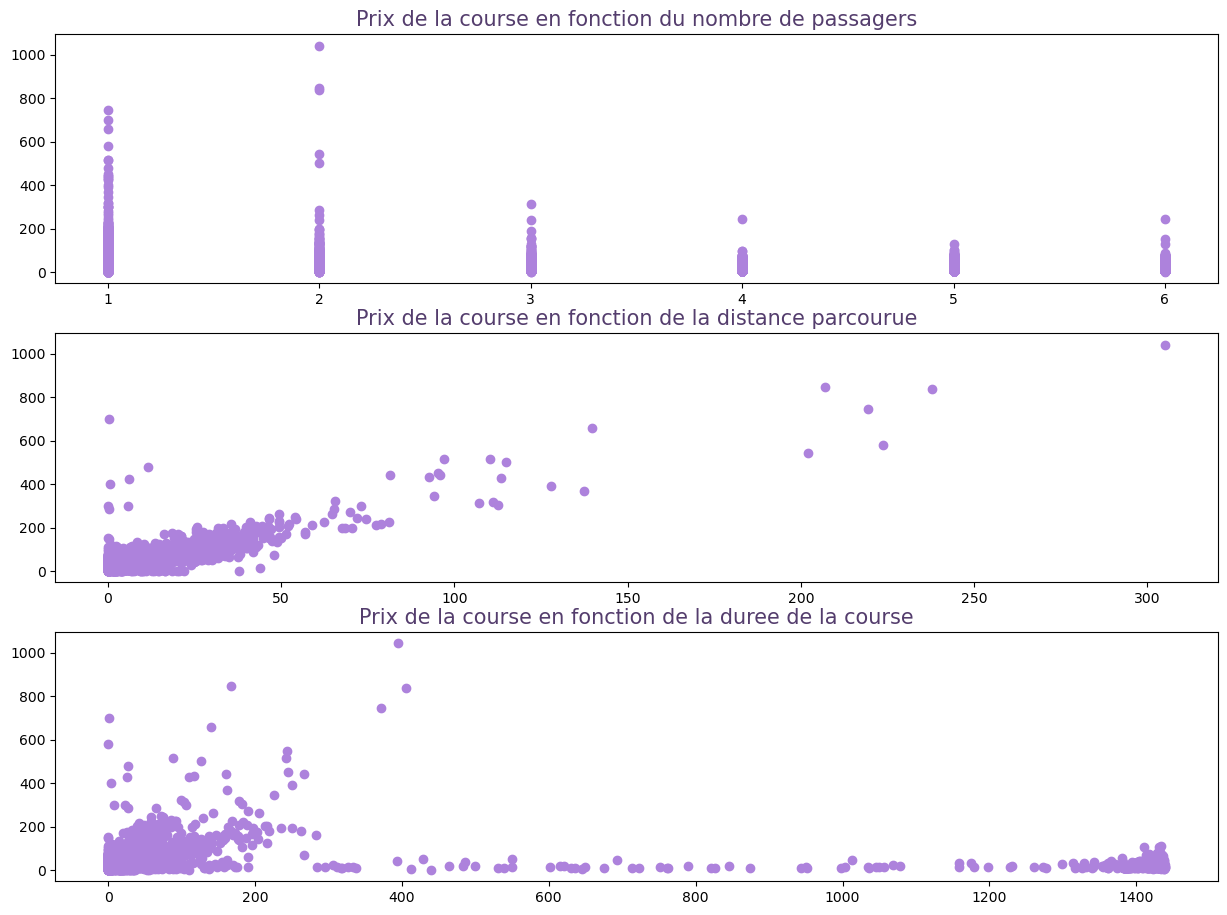

In [41]:
plt.figure(figsize=(15,11))

#Variable passenger_count
plt.subplot(3,1,1)
plt.scatter(x=taxi['passenger_count'],y=taxi['total_amount'], color='#ad82dc')
plt.title("Prix de la course en fonction du nombre de passagers", fontsize=15, color='#543d6d')

#Variable trip_distance
plt.subplot(3,1,2)
plt.scatter(x=taxi['trip_distance'],y=taxi['total_amount'], color='#ad82dc')
plt.title("Prix de la course en fonction de la distance parcourue", fontsize=15, color='#543d6d')

#Variable duree
plt.subplot(3,1,3)
plt.scatter(x=taxi['duree'],y=taxi['total_amount'], color='#ad82dc')
plt.title("Prix de la course en fonction de la duree de la course", fontsize=15, color='#543d6d')

plt.show()

#### Croisement de plusieurs variables quantitatives et de la variable total  

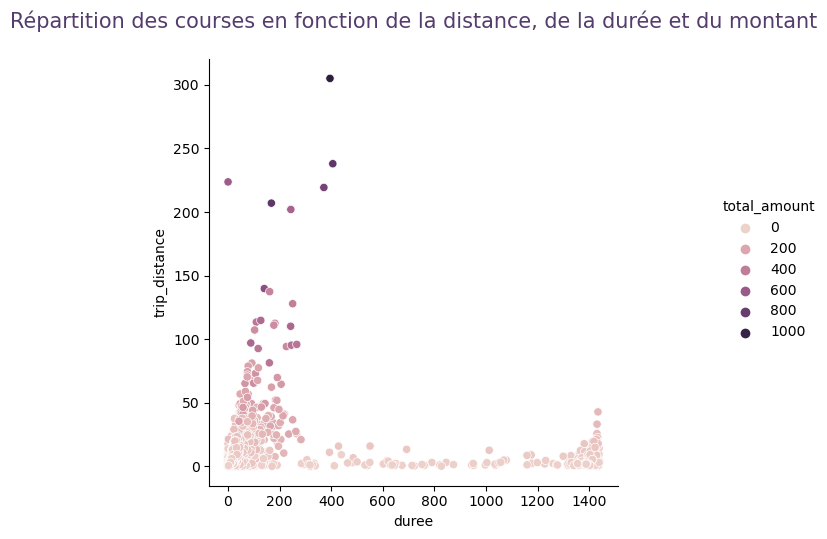

In [42]:
#Variables duree, distance et total
sb.relplot(x=taxi['duree'], y=taxi['trip_distance'], hue=taxi['total_amount'])
plt.title("Répartition des courses en fonction de la distance, de la durée et du montant\n", fontsize=15, color='#543d6d')
plt.show()

#### Variables qualitatives + variables total et distance  

Nous allons maintenant réaliser des croisements entre nos variables qualitatives et notre variable à expliquer, qui est le total du prix de la course. Nous allons ajouter la variable distance pour ajouter de l'information sur nos graphiques.

<Figure size 1200x800 with 0 Axes>

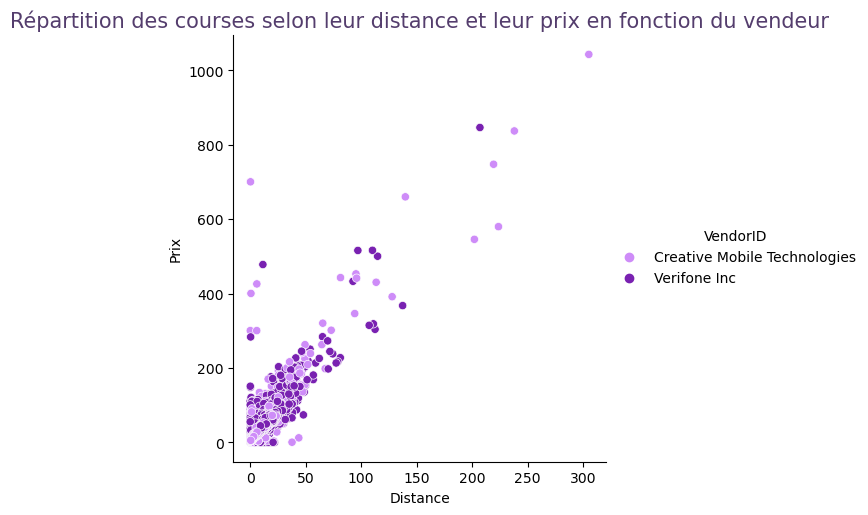

In [43]:
#Variable VendorID
plt.figure(figsize=(12,8))
sb.relplot(x=taxi['trip_distance'], y=taxi['total_amount'], hue=taxi['VendorID'], palette=['#ce8cf8', '#7921b1'])
plt.title("Répartition des courses selon leur distance et leur prix en fonction du vendeur", fontsize=15, color='#543d6d')
plt.xlabel("Distance")
plt.ylabel("Prix")
plt.show()

<Figure size 1200x800 with 0 Axes>

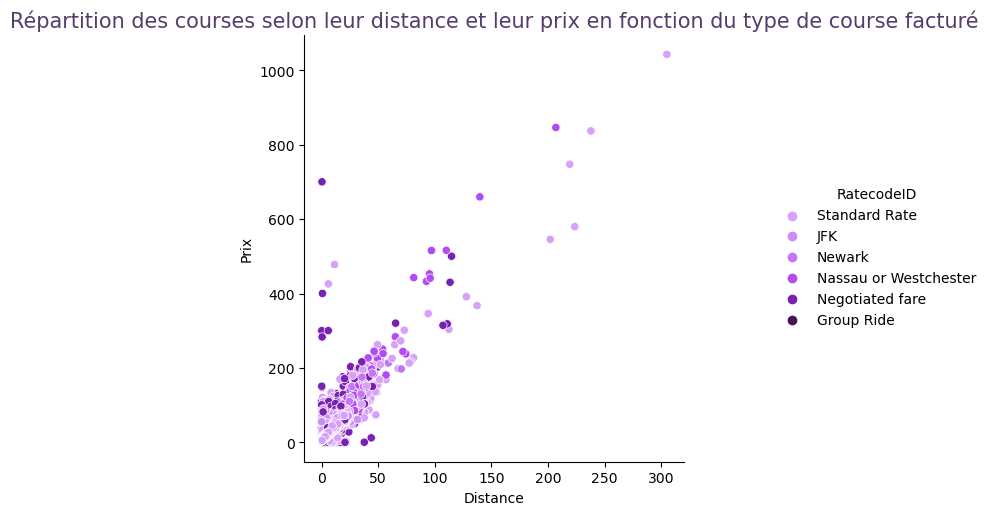

In [44]:
#Variable RatecodeID
plt.figure(figsize=(12,8))
sb.relplot(x=taxi['trip_distance'], y=taxi['total_amount'], hue=taxi['RatecodeID'], 
           palette=['#d7a1f9', '#ce8cf8', '#c576f6', '#b24bf3', '#7921b1', '#461257'])
plt.title("Répartition des courses selon leur distance et leur prix en fonction du type de course facturé", 
          fontsize=15, color='#543d6d')
plt.xlabel("Distance")
plt.ylabel("Prix")
plt.show()

<Figure size 1200x800 with 0 Axes>

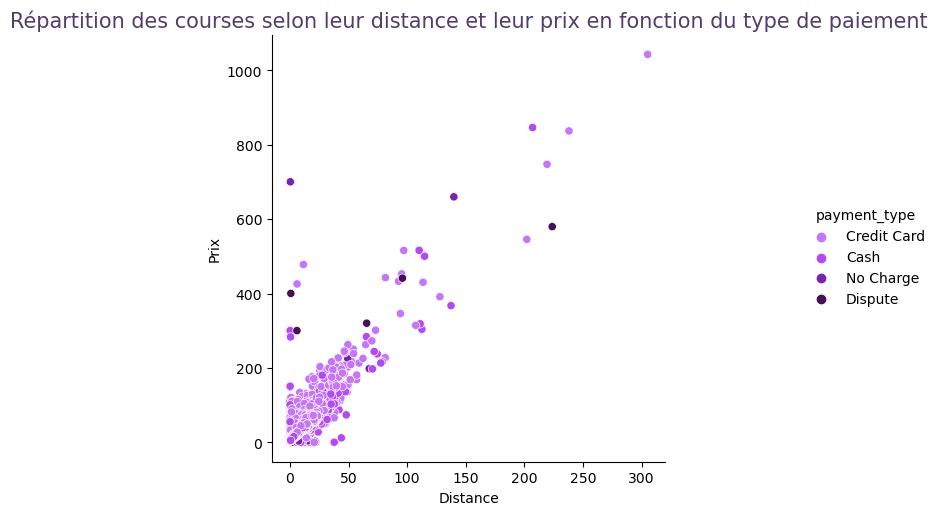

In [45]:
#Variable payment_type
plt.figure(figsize=(12,8))
sb.relplot(x=taxi['trip_distance'], y=taxi['total_amount'], hue=taxi['payment_type'], 
           palette=['#c576f6', '#b24bf3', '#7921b1', '#461257'])
plt.title("Répartition des courses selon leur distance et leur prix en fonction du type de paiement", 
          fontsize=15, color='#543d6d')
plt.xlabel("Distance")
plt.ylabel("Prix")
plt.show()

<Figure size 1200x800 with 0 Axes>

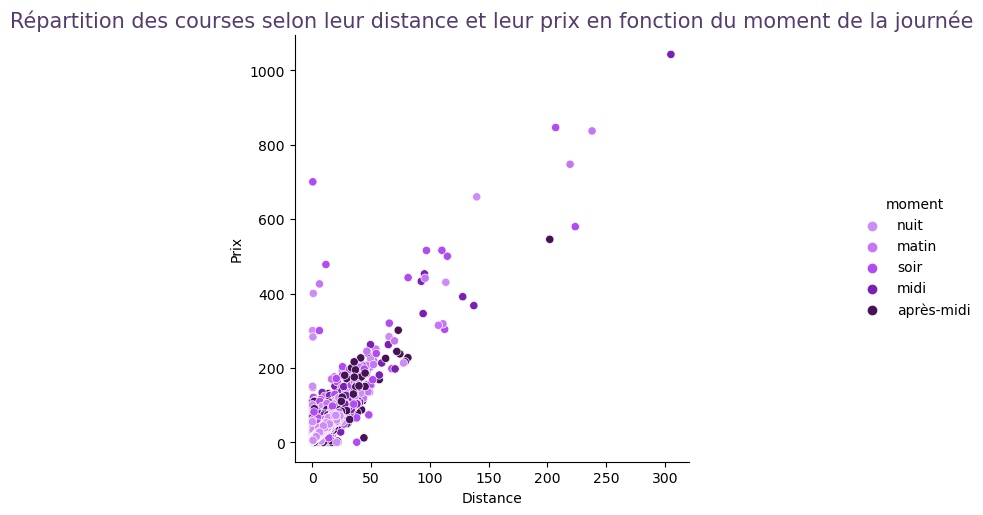

In [46]:
#Variable moment
plt.figure(figsize=(12,8))
sb.relplot(x=taxi['trip_distance'], y=taxi['total_amount'], hue=taxi['moment'], 
           palette=['#ce8cf8', '#c576f6', '#b24bf3', '#7921b1', '#461257'])
plt.title("Répartition des courses selon leur distance et leur prix en fonction du moment de la journée", 
          fontsize=15, color='#543d6d')
plt.xlabel("Distance")
plt.ylabel("Prix")
plt.show()

<Figure size 1200x800 with 0 Axes>

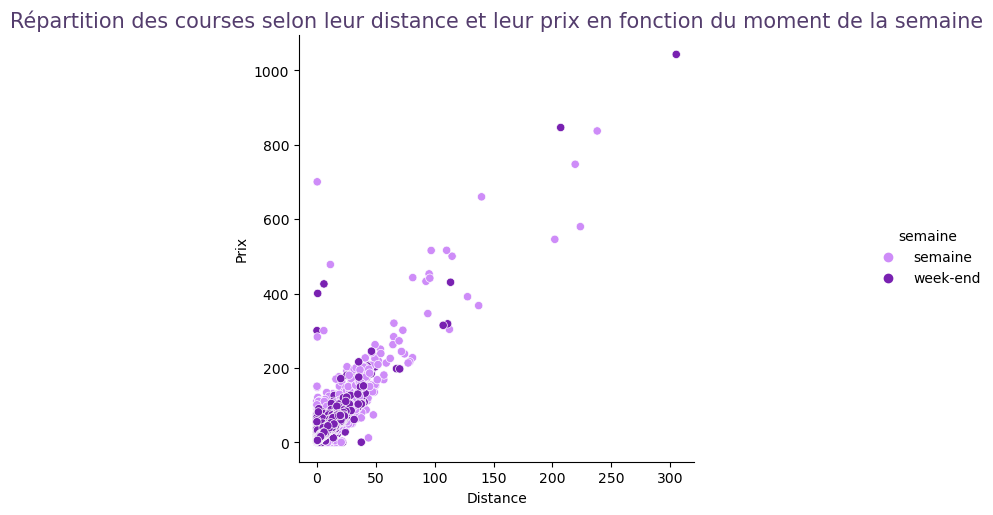

In [47]:
#Variable semaine
plt.figure(figsize=(12,8))
sb.relplot(x=taxi['trip_distance'], y=taxi['total_amount'], hue=taxi['semaine'], palette=['#ce8cf8', '#7921b1'])
plt.title("Répartition des courses selon leur distance et leur prix en fonction du moment de la semaine", 
          fontsize=15, color='#543d6d')
plt.xlabel("Distance")
plt.ylabel("Prix")
plt.show()

## Modélisation 

Nos données sont prêtes, nous pouvons commencer la réalisation de nos modèles.

### Création du jeu de données utilisé pour les modèles 

Pour réaliser nos modèles, nous allons utiliser un jeu de données contenant des variables dummies qui vont représenter les variables qualitatives. En effet, la création de variables dummies est souvent nécessaire lors de l'utilisation de modèles d'apprentissage automatique qui ne peuvent traiter que des données numériques. Comme les variables quantitatives sont déjà numériques, on n'y touche pas. 

In [48]:
taxi_quanti = taxi.drop(['VendorID','RatecodeID','payment_type', 'moment', 'semaine'], axis=1)  # Supprime la variable catégorielle des données quantitatives
taxi_dummies = pd.get_dummies(taxi[['VendorID','RatecodeID','payment_type', 'moment', 'semaine']], prefix='cat')  # Crée des dummies pour la variable catégorielle

In [49]:
# Concatène les données quantitatives et les dummies
taxi_fin = pd.concat([taxi_quanti, taxi_dummies], axis=1)

In [50]:
#on garde qu'une colonne pour les variables a 2 modalités
taxi_fin=taxi_fin.drop(['cat_Verifone Inc', 'cat_week-end'],
               axis=1)

In [51]:
taxi_fin = taxi_fin.rename(columns={'cat_Creative Mobile Technologies': 'cat_VendorID', # 1=Creative Mobile Technologies, O=Verifone Inc
                          'cat_semaine':'cat_semaine' #1=semaine, 0=week-end
                       })

In [52]:
info_df(taxi_fin)

le fichier contient 269674 individus et 21 variables

Les variables du fichier sont : 
	- passenger_count
	- trip_distance
	- total_amount
	- duree
	- cat_VendorID
	- cat_Standard Rate
	- cat_JFK
	- cat_Newark
	- cat_Nassau or Westchester
	- cat_Negotiated fare
	- cat_Group Ride
	- cat_Credit Card
	- cat_Cash
	- cat_No Charge
	- cat_Dispute
	- cat_après-midi
	- cat_matin
	- cat_midi
	- cat_nuit
	- cat_soir
	- cat_semaine


In [53]:
#aperçu du df
taxi_fin.head(10)

,passenger_count,trip_distance,total_amount,duree,cat_VendorID,cat_Standard Rate,cat_JFK,cat_Newark,cat_Nassau or Westchester,cat_Negotiated fare,...,cat_Credit Card,cat_Cash,cat_No Charge,cat_Dispute,cat_après-midi,cat_matin,cat_midi,cat_nuit,cat_soir,cat_semaine
1,2,0.40,5.80,2.67,1,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
2,1,0.30,4.80,2.22,1,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
3,1,1.70,10.80,5.60,1,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
6,1,2.90,15.80,17.97,1,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
7,1,1.50,12.95,6.17,1,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
8,1,2.00,12.80,9.82,1,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
9,1,0.50,8.30,3.40,1,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
10,1,3.37,17.88,12.53,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
11,1,1.41,8.30,7.38,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
12,1,1.06,9.80,5.57,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1


In [54]:
taxi_fin=taxi_fin.astype({'trip_distance':'int32', 'total_amount':'int32', 'duree':'int32',
       'cat_VendorID':'int32', 'cat_Standard Rate':'int32', 'cat_JFK':'int32', 'cat_Newark':'int32',
       'cat_Nassau or Westchester':'int32', 'cat_Negotiated fare':'int32', 'cat_Group Ride':'int32',
       'cat_Credit Card':'int32', 'cat_Cash':'int32', 'cat_No Charge':'int32', 'cat_Dispute':'int32',
       'cat_après-midi':'int32', 'cat_matin':'int32', 'cat_midi':'int32', 'cat_nuit':'int32', 'cat_soir':'int32',
       'cat_semaine':'int32'})

In [55]:
taxi_fin.columns

Index(['passenger_count', 'trip_distance', 'total_amount', 'duree',
       'cat_VendorID', 'cat_Standard Rate', 'cat_JFK', 'cat_Newark',
       'cat_Nassau or Westchester', 'cat_Negotiated fare', 'cat_Group Ride',
       'cat_Credit Card', 'cat_Cash', 'cat_No Charge', 'cat_Dispute',
       'cat_après-midi', 'cat_matin', 'cat_midi', 'cat_nuit', 'cat_soir',
       'cat_semaine'],
      dtype='object')

### Analyse de la corrélation 

Avant de créer nos modèles, nous allons analyser la corrélation entre nos variables. Cela va permettre d'éviter les redondances d'informations et de baisier les performances de nos modèles.

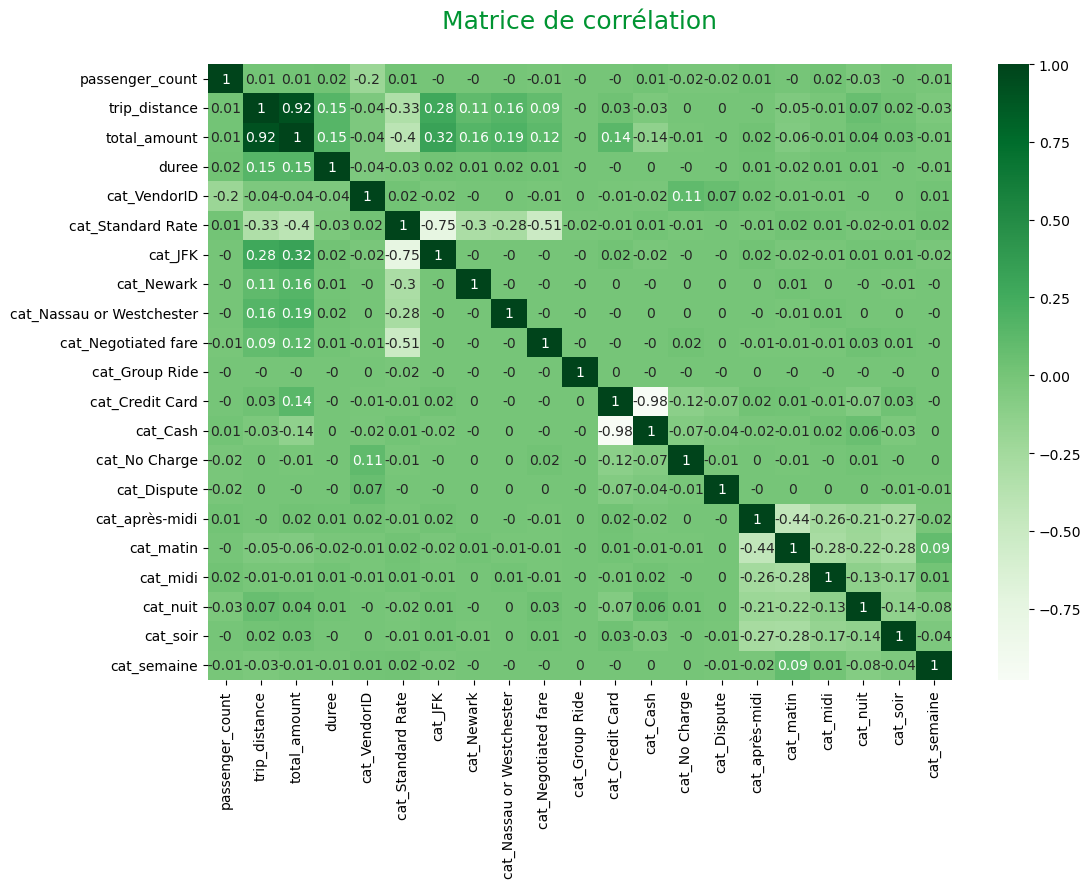

In [56]:
#Matrice de corrélation
plt.figure(figsize=(12,8))
sb.heatmap(taxi_fin.corr().round(2), annot=True, cmap='Greens')
plt.title("Matrice de corrélation\n", fontsize=18, color='#009432')
plt.show()

Nous observons une forte corrélation entre le prix et la distance. Comme le prix est la variable à expliquer, nous décidons de conserver les 2 variables. Mais nous ren déduisons que la distance a une forte influence sur le prix d'une course.

### Echantillon apprentissage et test : 

Avant de réaliser nos modèles, il est important de séparer notre jeu de données en un échantillon d'apprentissage et un échantillon de test, qui vont contenir respectivement 80% et 20% de nos données. L'échantillon d'apprentissage va permettre d'entraîner le modèle et l'échantillon de test va permettre de tester les performances du modèle.

In [57]:
#Import du package
from sklearn.model_selection import train_test_split #découper en app et test

In [58]:
#Variable à expliquer
Y=taxi_fin["total_amount"]

In [59]:
#Variables explicatives
X=taxi_fin.drop(["total_amount"],axis=1)

In [60]:
#Découpage
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.2, random_state=5)

In [61]:
info_df(X_train)

le fichier contient 215739 individus et 20 variables

Les variables du fichier sont : 
	- passenger_count
	- trip_distance
	- duree
	- cat_VendorID
	- cat_Standard Rate
	- cat_JFK
	- cat_Newark
	- cat_Nassau or Westchester
	- cat_Negotiated fare
	- cat_Group Ride
	- cat_Credit Card
	- cat_Cash
	- cat_No Charge
	- cat_Dispute
	- cat_après-midi
	- cat_matin
	- cat_midi
	- cat_nuit
	- cat_soir
	- cat_semaine


In [62]:
info_df(X_test)

le fichier contient 53935 individus et 20 variables

Les variables du fichier sont : 
	- passenger_count
	- trip_distance
	- duree
	- cat_VendorID
	- cat_Standard Rate
	- cat_JFK
	- cat_Newark
	- cat_Nassau or Westchester
	- cat_Negotiated fare
	- cat_Group Ride
	- cat_Credit Card
	- cat_Cash
	- cat_No Charge
	- cat_Dispute
	- cat_après-midi
	- cat_matin
	- cat_midi
	- cat_nuit
	- cat_soir
	- cat_semaine


### Place aux différents modèles 

#### 1- Régession linéaire 

In [63]:
#Import des packages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [64]:
#Création du modèle
lmodellineaire=LinearRegression()

In [65]:
#Entraînement du modèle
lmodellineaire.fit(X_train, Y_train)

LinearRegression()

In [66]:
#scores
print("Training score", lmodellineaire.score(X_train, Y_train))
print("Test score", lmodellineaire.score(X_test, Y_test))

Training score 0.8928650731856556
Test score 0.8332479715675063


In [67]:
#Evaluation du training set
from sklearn.metrics import r2_score
Y_train_predict=lmodellineaire.predict(X_train)
rmse=(np.sqrt(mean_squared_error(Y_train,Y_train_predict)))
rmae=(np.sqrt(mean_absolute_error(Y_train,Y_train_predict)))

print('La performance du modèle sur la base d`apprentissage')
print('-----------------------------------------------------')
print('L`erreur quadratique moyenne est de {}'.format(rmse))
print('L`erreur absolue moyenne est de {}'.format(rmae))

La performance du modèle sur la base d`apprentissage
-----------------------------------------------------
L`erreur quadratique moyenne est de 4.049963244183734
L`erreur absolue moyenne est de 1.3786881313959918


#### Arbre de régression 

In [68]:
#Import du package
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [69]:
#Création du modèle
model_DTReg=DecisionTreeRegressor(max_depth=3)

In [70]:
#Entraînement du modèle
model_DTReg.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=3)

In [71]:
#scores
print("Training score", model_DTReg.score(X_train, Y_train))
print("Test score", model_DTReg.score(X_test, Y_test))

Training score 0.8050539295318169
Test score 0.7180741717179906


In [72]:
#Evaluation du training set
Y_train_predict=model_DTReg.predict(X_train)
rmse=(np.sqrt(mean_squared_error(Y_train,Y_train_predict)))
rmae=(np.sqrt(mean_absolute_error(Y_train,Y_train_predict)))

print('La performance du modèle sur la base d`apprentissage')
print('-----------------------------------------------------')
print('L`erreur quadratique moyenne est de {}'.format(rmse))
print('L`erreur absolue moyenne est de {}'.format(rmae))

La performance du modèle sur la base d`apprentissage
-----------------------------------------------------
L`erreur quadratique moyenne est de 5.463145734523272
L`erreur absolue moyenne est de 1.6530487443501374


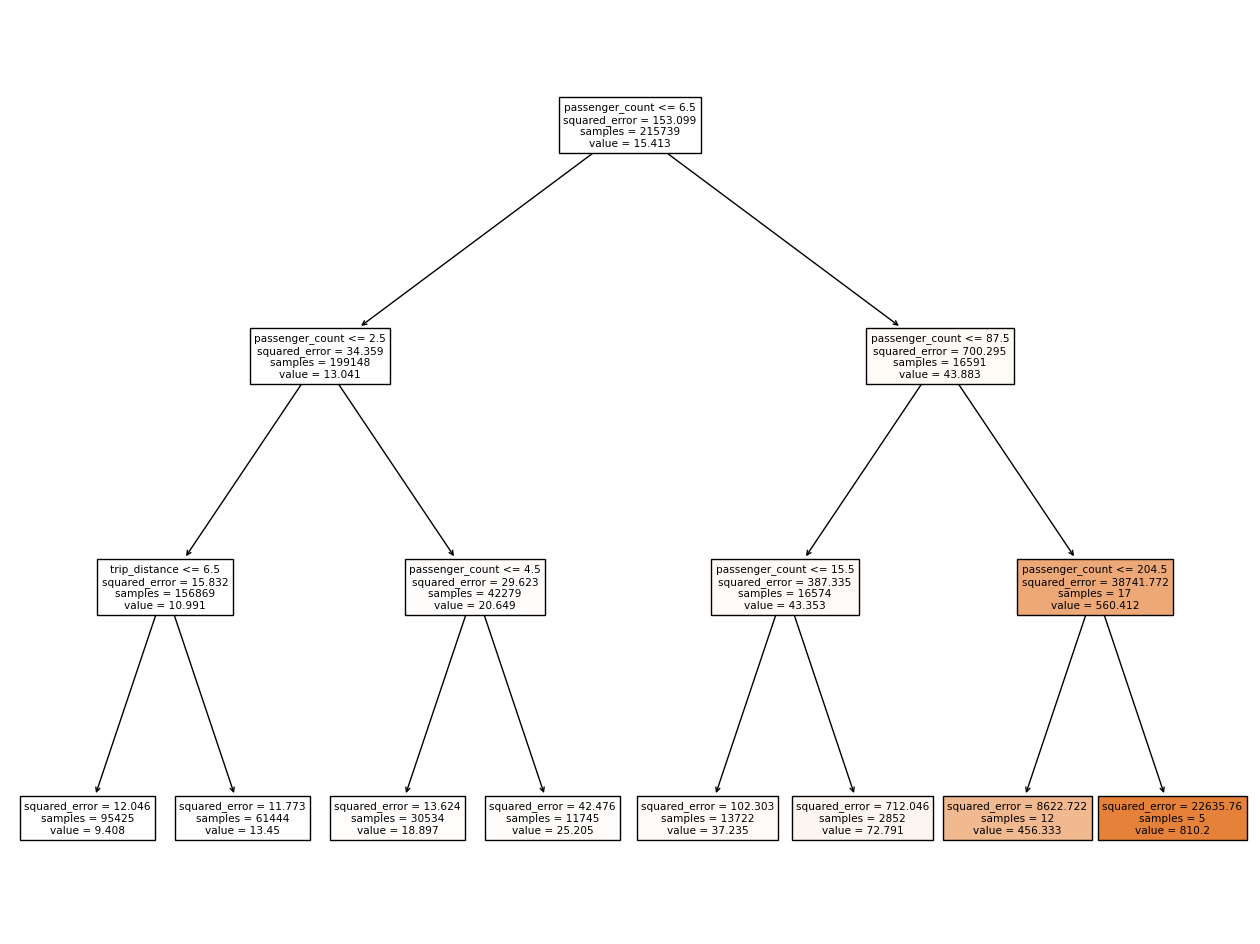

In [73]:
#Affichage de l'arbre
plt.figure(figsize=(16,12))
plot_tree(model_DTReg, feature_names=['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'payment_type', 
                                      'total_amount', 'duree', 'moment', 'semaine'], 
          class_names=['total_amount'], filled=True)
plt.show()

In [74]:
X_train.head()

,passenger_count,trip_distance,duree,cat_VendorID,cat_Standard Rate,cat_JFK,cat_Newark,cat_Nassau or Westchester,cat_Negotiated fare,cat_Group Ride,cat_Credit Card,cat_Cash,cat_No Charge,cat_Dispute,cat_après-midi,cat_matin,cat_midi,cat_nuit,cat_soir,cat_semaine
255459,1,1,12,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
164878,1,0,5,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
135579,1,0,5,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
63036,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
86097,3,0,4,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1


#### Random forest 

In [75]:
#Import du package
from sklearn.ensemble import RandomForestRegressor

In [76]:
#Création du modèle
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

In [77]:
#Entraînement du modèle
rf.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [78]:
#scores
print("Training score", rf.score(X_train, Y_train))
print("Test score", rf.score(X_test, Y_test))

Training score 0.9652327743569551
Test score 0.849365228908164


In [79]:
#Evaluation du training set
Y_train_predict=rf.predict(X_train)
rmse=(np.sqrt(mean_squared_error(Y_train,Y_train_predict)))
rmae=(np.sqrt(mean_absolute_error(Y_train,Y_train_predict)))

print('La performance du modèle sur la base d`apprentissage')
print('-----------------------------------------------------')
print('L`erreur quadratique moyenne est de {}'.format(rmse))
print('L`erreur absolue moyenne est de {}'.format(rmae))

La performance du modèle sur la base d`apprentissage
-----------------------------------------------------
L`erreur quadratique moyenne est de 2.3071220038039666
L`erreur absolue moyenne est de 1.1040912253585817
